<a href="https://colab.research.google.com/github/BearKS/Robotic-weed-control-system/blob/feature%2Fextraction/Weed_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/qubvel/segmentation_models/blob/master/examples/binary%20segmentation%20(camvid).ipynb

In [ ]:
#segmentation model lib
!pip install albumentations>=0.3.0 
!pip install --pre segmentation-models
#

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Loading dataset

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import keras

In [ ]:
!gdown https://drive.google.com/uc?id=1lWSlbUkUFFIWx2IQmgzZ-RF6Gd_WqD4Y&export=download

Downloading...
From: https://drive.google.com/uc?id=1lWSlbUkUFFIWx2IQmgzZ-RF6Gd_WqD4Y
To: /content/predataset2.zip
100% 1.59G/1.59G [00:06<00:00, 229MB/s]


In [ ]:
!unzip predataset2

Archive:  predataset2.zip
replace predataset/test/images/T02_Box007_2017-09-09T08-52-40-045.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: predataset/test/images/T02_Box007_2017-09-09T08-52-40-045.png  
  inflating: predataset/test/images/T02_Box007_2017-09-10T05-55-35-248.png  
  inflating: predataset/test/images/T02_Box007_2017-09-11T10-38-11-116.png  
  inflating: predataset/test/images/T02_Box007_2017-09-28T10-42-55-040.png  
  inflating: predataset/test/images/T02_Box007_2017-09-29T11-27-55-959.png  
  inflating: predataset/test/images/T02_Box007_2017-10-04T10-15-38-256.png  
  inflating: predataset/test/images/T02_Box007_2017-10-06T13-40-15-271.png  
  inflating: predataset/test/images/T02_Box007_2017-10-15T05-42-26-641.png  
  inflating: predataset/test/images/T02_Box029_2017-09-12T08-51-39-191.png  
  inflating: predataset/test/images/T02_Box029_2017-09-14T08-35-48-889.png  
  inflating: predataset/test/images/T02_Box029_2017-09-17T11-28-36-738.png  
  inflating: pre

In [ ]:
DATA_DIR = 'predataset/'

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        # plt.xticks([])
        # plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['plant']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloader(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [ ]:
import random

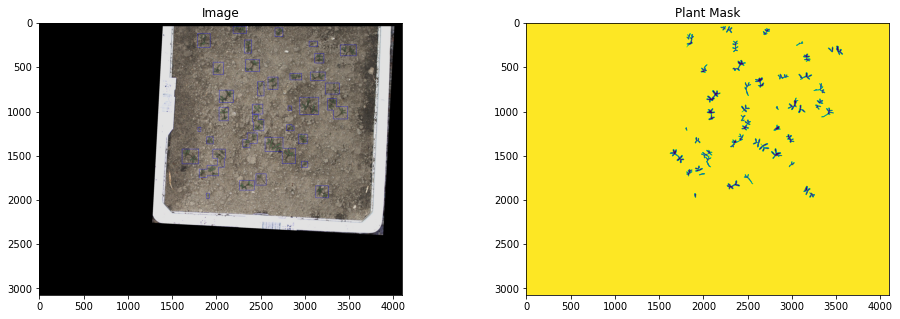

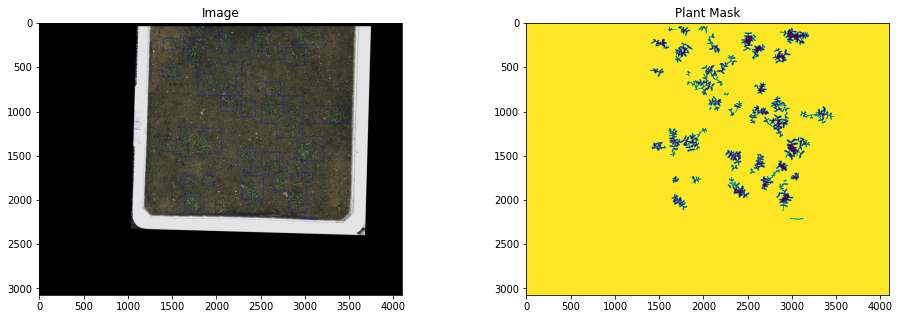

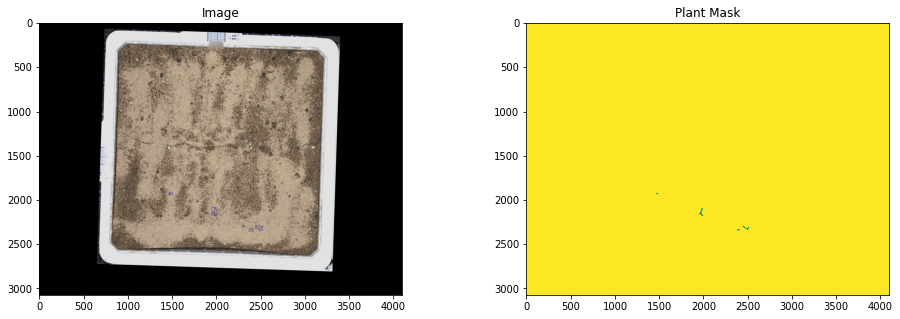

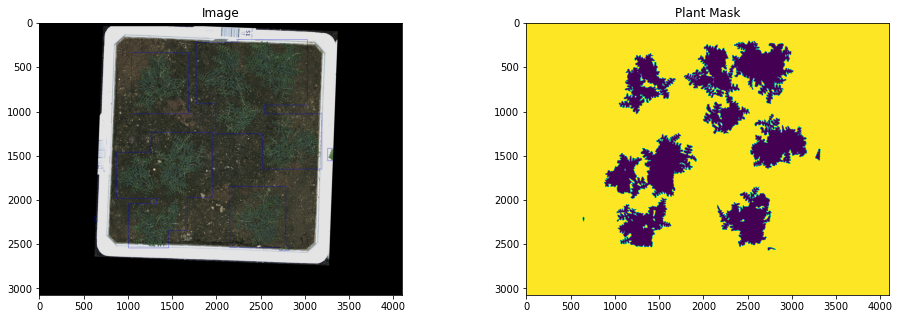

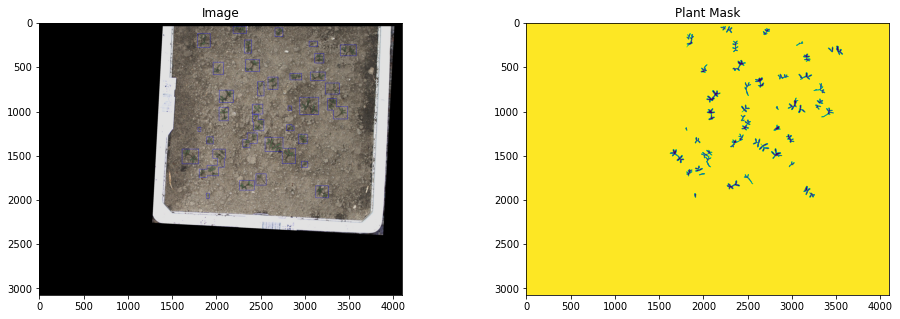

In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['plant'])

# image, mask = dataset[5] # get some sample
for i in range(5):
  idx = random.randint(0, len(dataset)-1)
  image, mask = dataset[idx] # get some sample
  visualize(
      image=image, 
      plant_mask=mask[..., 0].squeeze(),
      # sky_mask=mask[..., 1].squeeze(),
      # background_mask=mask[..., 2].squeeze(),
  )

##Augmentations

In [ ]:
import albumentations as A

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=640, min_width=640, always_apply=False, border_mode=0),
        A.RandomCrop(height=640, width=640, always_apply=True),

        A.GaussNoise (p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1615: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


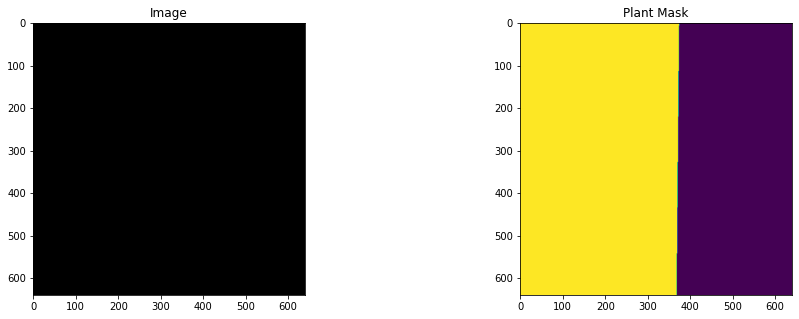

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['plant'], augmentation=get_training_augmentation())

# image, mask = dataset[12] # get some sample
for i in range(20):
  # idx = random.randint(0, len(dataset)-1)
  image, mask = dataset[i] # get some sample
visualize(
    image=image, 
    plant_mask=mask[..., 0].squeeze(),
    # sky_mask=mask[..., 1].squeeze(),
    # background_mask=mask[..., 2].squeeze(),
)

##Segmentation model training

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
#เรื่องของ ver
# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`
# ศึกษาโมเดลให้มากกว่านี้ รู้ว่าตัวแปลมันคืออะไร 

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
BACKBONE = 'vgg16'
BATCH_SIZE = 4
CLASSES = ['plant']
#คลาสคืออะไร
LR = 0.0001
EPOCHS = 60

preprocess_input = sm.get_preprocessing(BACKBONE)
#คืออะไร

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [ ]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 640, 640, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 640, 640, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/60
25/25 [==============================] - 225s 8s/step - loss: 0.5142 - iou_score: 0.2830 - f1-score: 0.4363 - val_loss: 0.8013 - val_iou_score: 0.1869 - val_f1-score: 0.3147 - lr: 1.0000e-04
Epoch 2/60
25/25 [==============================] - 168s 7s/step - loss: 0.4555 - iou_score: 0.4245 - f1-score: 0.5920 - val_loss: 0.5294 - val_iou_score: 0.3480 - val_f1-score: 0.5154 - lr: 1.0000e-04
Epoch 3/60
25/25 [==============================] - 137s 6s/step - loss: 0.3989 - iou_score: 0.5267 - f1-score: 0.6849 - val_loss: 0.5049 - val_iou_score: 0.3827 - val_f1-score: 0.5522 - lr: 1.0000e-04
Epoch 4/60
25/25 [==============================] - 137s 6s/step - loss: 0.3847 - iou_score: 0.5835 - f1-score: 0.7277 - val_loss: 0.5715 - val_iou_score: 0.3399 - val_f1-score: 0.5028 - lr: 1.0000e-04
Epoch 5/60
25/25 [==============================] - 138s 6s/step - loss: 0.3488 - iou_score: 0.5886 - f1-score: 0.7311 - val_loss: 0.3553 - val_iou_score: 0.4600 - val_f1-score: 0.6284 - lr: 1

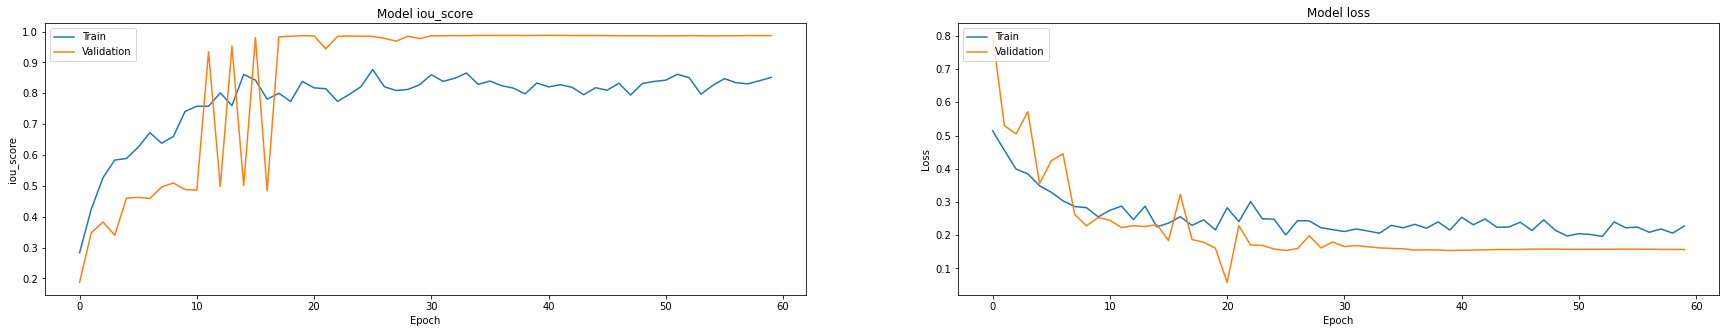

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##Model Evaluation

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# load best weights
model.load_weights('best_model.h5')

In [ ]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

16/16 [==============================] - 29s 2s/step - loss: 0.0546 - iou_score: 0.9883 - f1-score: 0.9941
Loss: 0.054566
mean iou_score: 0.98829
mean f1-score: 0.99407


##Visualization of results on test dataset

1/1 [==============================] - 0s 184ms/step


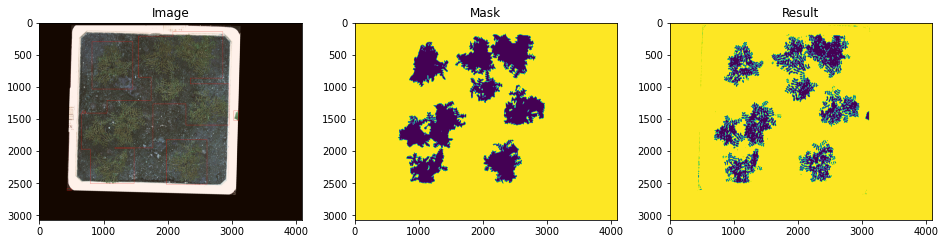

1/1 [==============================] - 0s 113ms/step


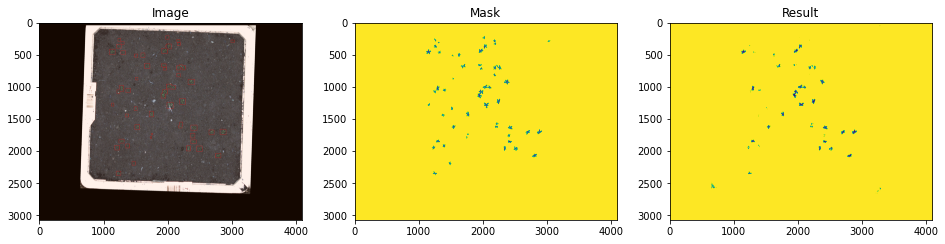

1/1 [==============================] - 0s 110ms/step


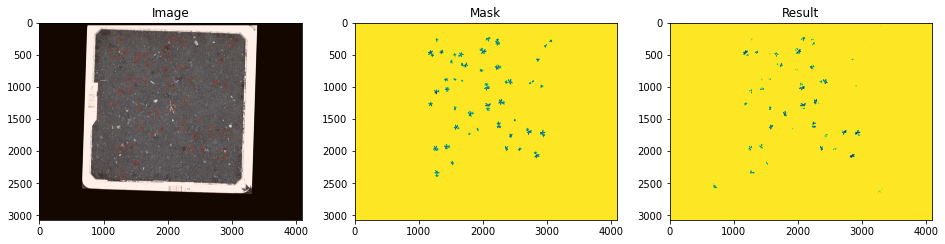

1/1 [==============================] - 0s 111ms/step


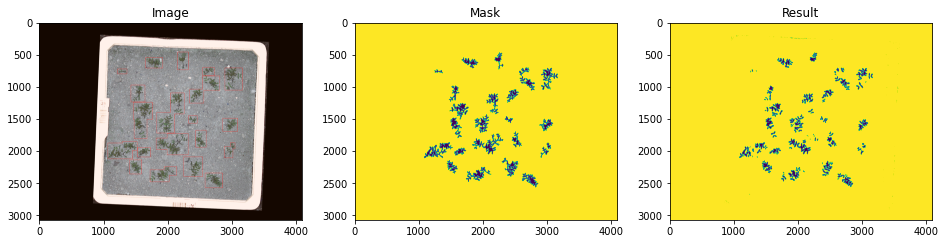

1/1 [==============================] - 0s 326ms/step


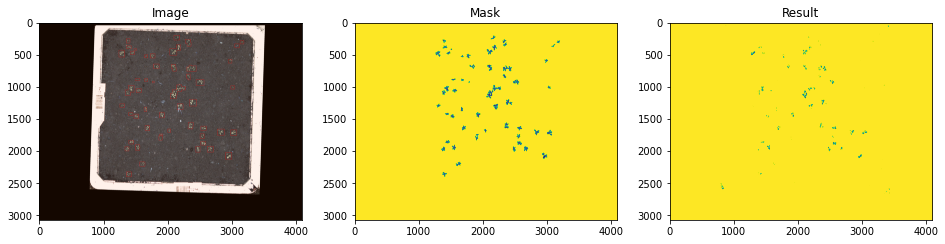

1/1 [==============================] - 0s 125ms/step


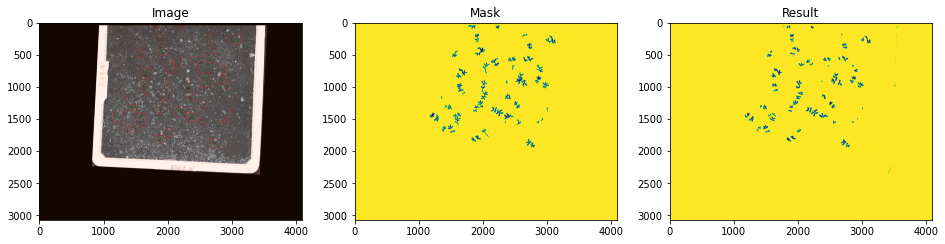

1/1 [==============================] - 0s 114ms/step


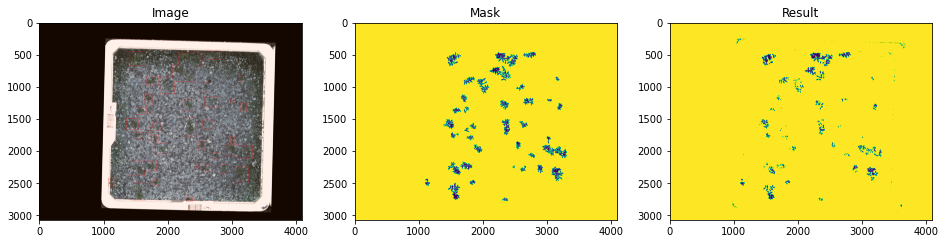

1/1 [==============================] - 0s 111ms/step


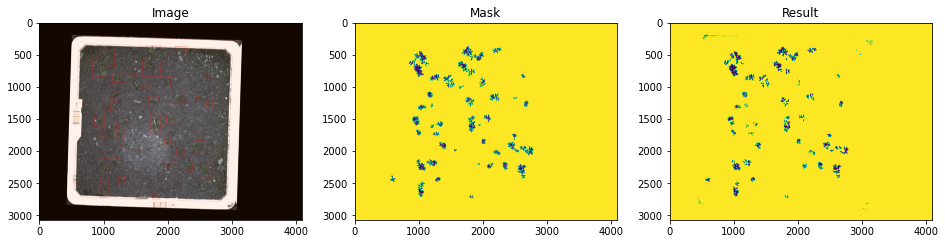

1/1 [==============================] - 0s 104ms/step


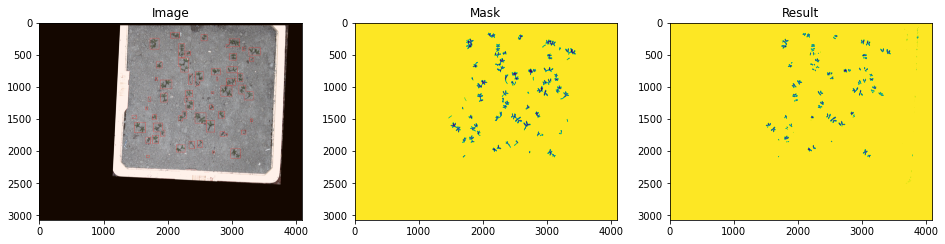

1/1 [==============================] - 0s 108ms/step


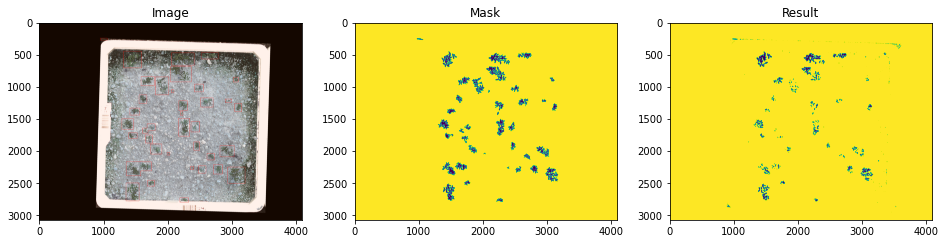

1/1 [==============================] - 0s 110ms/step


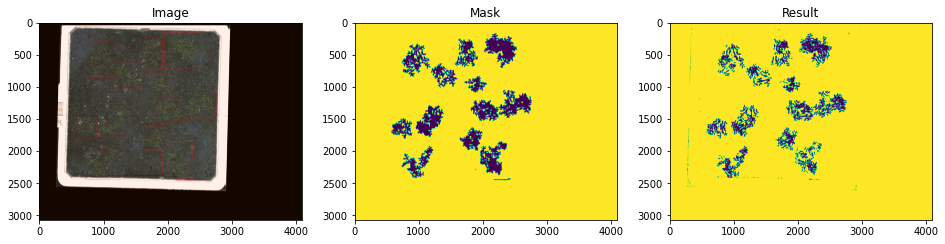

1/1 [==============================] - 0s 114ms/step


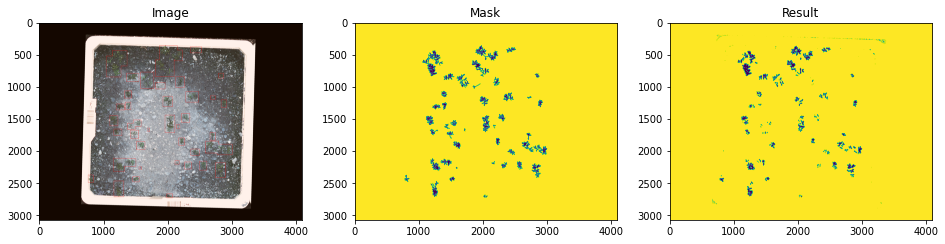

1/1 [==============================] - 0s 107ms/step


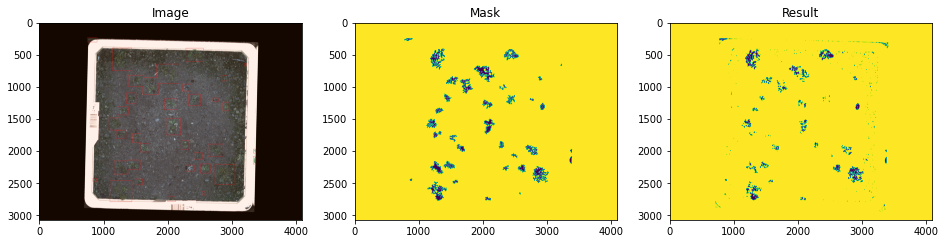

1/1 [==============================] - 0s 109ms/step


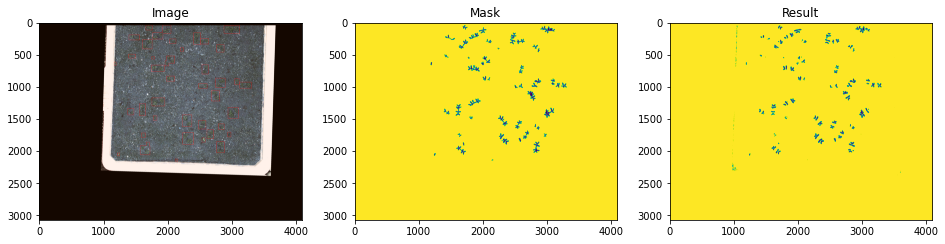

1/1 [==============================] - 0s 106ms/step


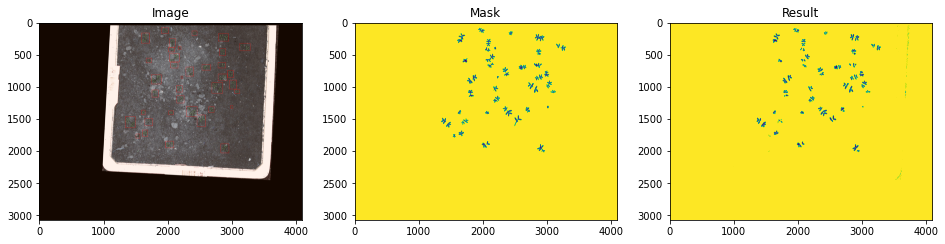

1/1 [==============================] - 0s 111ms/step


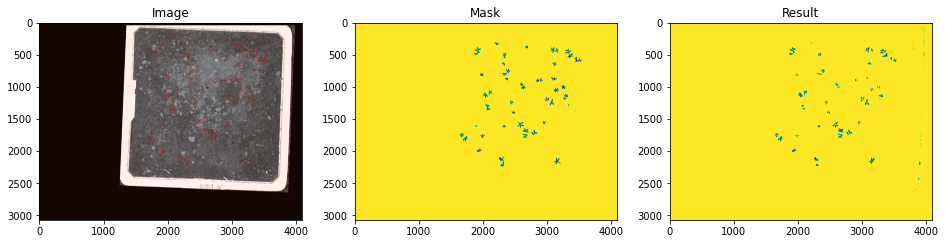

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in range(len(test_dataset)):
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    result = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        mask= gt_mask[..., 0].squeeze(),
        result = result[..., 0].squeeze(),
    )

In [ ]:
# copy it there
!cp best_model.h5 /content/drive/MyDrive

(1080, 1920, 3)
(1024, 1920, 3)
1/1 [==============================] - 13s 13s/step


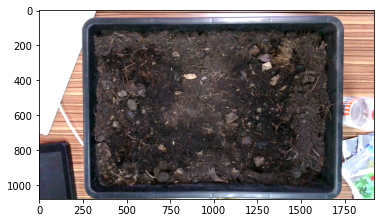

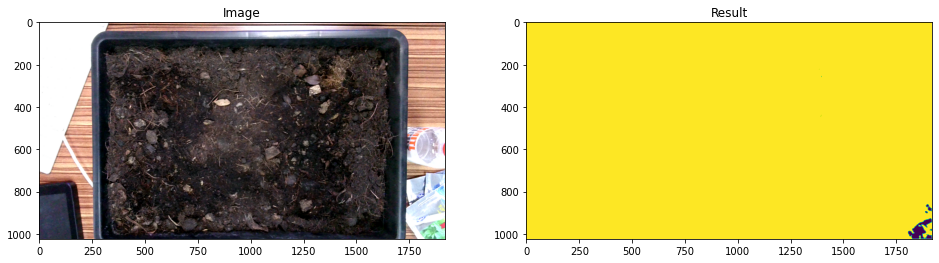

In [ ]:
image = cv2.imread('/content/Copy of RWSIP_20220829_153619.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = np.expand_dims(image, axis=0)
print(image.shape)
crop = image[0:1024, 0:1920] 
print(crop.shape)
plt.imshow(image)
# plt.imshow(crop)
# cv2.imshow("Cropped", crop)
crop = np.expand_dims(crop, axis=0)
result = model.predict(crop).round()
    
visualize(
    image=denormalize(crop.squeeze()),
    result = result[..., 0].squeeze(),
    )

(1474, 1110, 3)
(1472, 1088, 3)
1/1 [==============================] - 13s 13s/step


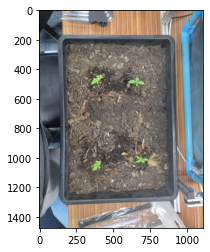

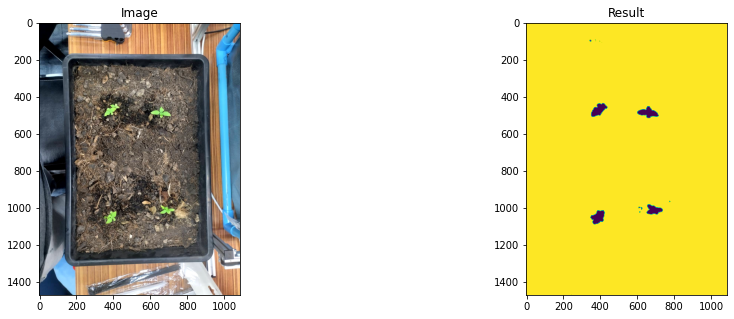

In [ ]:
image = cv2.imread('/content/41374.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = np.expand_dims(image, axis=0)
print(image.shape)
crop = image[0:1472, 0:1088] 
print(crop.shape)
plt.imshow(image)
# plt.imshow(crop)
# cv2.imshow("Cropped", crop)
crop = np.expand_dims(crop, axis=0)
result = model.predict(crop).round()
    
visualize(
    image=denormalize(crop.squeeze()),
    result = result[..., 0].squeeze(),
    )